# Hidden Markov models {#sec-hmms}

In [ ]:
#| code-fold: true

# Colab setup ------------------
import os, shutil, sys, subprocess, urllib.request
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade polars hmmlearn iqplot colorcet bebi103 arviz cmdstanpy watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    from cmdstanpy.install_cmdstan import latest_version
    cmdstan_version = latest_version()
    cmdstan_url = f"https://github.com/stan-dev/cmdstan/releases/download/v{cmdstan_version}/"
    fname = f"colab-cmdstan-{cmdstan_version}.tgz"
    urllib.request.urlretrieve(cmdstan_url + fname, fname)
    shutil.unpack_archive(fname)
    os.environ["CMDSTAN"] = f"./cmdstan-{cmdstan_version}"
    data_path = "https://s3.amazonaws.com/bebi103.caltech.edu/data/"

else:
    data_path = "../data/"
# ------------------------------

In [2]:
import numpy as np
import polars as pl
import scipy.stats as st

import cmdstanpy
import arviz as az

import sklearn.mixture

from hmmlearn import hmm

import daft

import bebi103

import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

Consider the following experiment. A mouse's movement is tracked over time. At each time point, we measure the mouse's velocity. We plot of the mouse's velocity over time is shown below.

In [3]:
df = pl.read_csv('mouse_speed.csv', comment_prefix='#')

p = bokeh.plotting.figure(
    frame_height=200, 
    frame_width=700,
    x_axis_label='time (s)',
    y_axis_label='speed (cm/s)',
    )
p.line(source=df.to_dict(), x='time (s)', y='speed (cm/s)')

bokeh.io.show(p)

We believe that the mouse may be in two states, a restful still state and a moving walking state. The restful state has a typical movement speed of $v_s$ and the moving state has a typical speed of $v_w$. We cannot observe the state of the mouse, but only its velocity. The state (still or moving) is a discrete (in this case categorical) latent variable, and the velocity is an observed variable. This is an example of an experiment that is amenable to a **hidden Markov model (HMM)**. In an HMM, a discrete latent variable changes state over time. At any given time point, the observed variable is dependent on the latent variable. This is shown graphically in the figure below. The latent variable at time point $t$ is $z_t$ and the observation at time point $t$ is $y_t$.

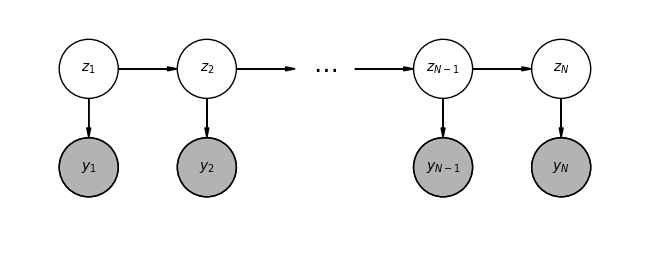

In [4]:
#| code-fold: true

# Create the PGM
pgm = daft.PGM([8, 3], origin=[0, 0], node_unit=1.5)

# Add hidden state nodes (z0, z1, z2,...)
pgm.add_node("z1", r"$z_1$", 1.0, 2.25, observed=False)
pgm.add_node("z2", r"$z_2$", 2.5, 2.25, observed=False)
pgm.add_node("dots", r"$\cdots$", 4.0, 2.25, fontsize=18, plot_params=dict(ec=None))
pgm.add_node("z3", r"$z_{N-1}$", 5.5, 2.25, observed=False)
pgm.add_node("z4", r"$z_N$", 7.0, 2.25, observed=False)

# Add observed nodes (y1, y2,...)
pgm.add_node("y1", r"$y_1$", 1.0, 1.0, observed=True)
pgm.add_node("y2", r"$y_2$", 2.5, 1.0, observed=True)
pgm.add_node("y3", r"$y_{N-1}$", 5.5, 1.0, observed=True)
pgm.add_node("y4", r"$y_N$", 7.0, 1.0, observed=True)

# Add edges for transition and emission
pgm.add_edge("z1", "z2")
pgm.add_edge("z2", "dots")
pgm.add_edge("dots", "z3")
pgm.add_edge("z3", "z4")
for i in range(1, 5):
    pgm.add_edge(f"z{i}", f"y{i}")

# Render the PGM
pgm.render();

## Generative model for HMMs

Let us now write down a generative model for a generic HMM. Let $K$ be the number of discrete states accessible to the latent variables. We define $\mathsf{\Gamma}$ to be the $K\times K$ **transition matrix**. $\Gamma_{ij}$ is the probability of a latent variable transitioning from state $i$ to state $j$ in a given time step. "Transitions" from $i$ to $i$ are allowed, and this is called the **self-loop probability**. Each row of $\mathsf{\Gamma}$, which we define as $\boldsymbol{\Gamma}_i$, therefore sums to one, 

$$\begin{align}
\sum_{j=1}^K \Gamma_{ij} = 1.
\end{align}
$$ 

Let ${z}_t \in [1, \ldots K]$ be the state at time point $t$. Let $\boldsymbol{\rho} = [\rho_1,\ldots,\rho_K]$ with $\rho_i$ being the probability that $z_1 = i$.

With these definitions in mind, we can write the generative model. The likelihood is parametrized by $\phi_z$, a set of parameters that depend on the identity of $z$ at a given time. That is to say that the likelihood for a given data point is $f(y_t\mid \phi_{z_t})$. In the context of HMMs, the likelihood is referred to as an **emission probability distribution**.

Putting it all together, the model for a HMM is

$$\begin{align}
&\text{priors for } \phi_z, \\[1em]
&\boldsymbol{\rho} \sim \text{prior for } \boldsymbol{\rho} \text{, usually Dirichlet},\\[1em]
&\boldsymbol{\Gamma}_i \sim \text{prior for } \boldsymbol{\Gamma}_i \text{, usually Dirichlet} \; \forall i,\\[1em]
&z_1 \mid \boldsymbol{\rho} \sim \text{Categorical}(\boldsymbol{\rho}),\\[1em] 
&z_t \mid z_{t-1}, \mathsf{\Gamma} \sim \text{Categorical}(\boldsymbol{\Gamma}_{z_{t-1}})\;\forall t\ge 2, \\[1em]
&y_t \mid z_t, \phi_{z_t} \sim \text{emission probability parametrized by } \phi_{z_t} \;\forall t.
\end{align}
$$


### Generative model for the mouse

For the mouse we are observing move and rest, there are two states ($K = 2$), moving and resting. We can model the velocity of the mouse in the respective states as Normally distributed with parameters $v_m, \sigma_m$ for moving and $v_s, \sigma_s$ for resting (still). This specifies our emission distribution with $\phi_z = \{\mu_z, \sigma_z\}$. The model is then (with speeds in units of cm/s)

$$\begin{align}
&v_s \sim \text{Norm}(0.5, 0.5),\\[1em]
&\sigma_s \sim \text{HalfNorm}(0, 1.0),\\[1em]
&v_m \sim \text{Norm}(8.0, 5.0),\\[1em]
&\sigma_m \sim \text{HalfNorm}(0, 10.0),\\[1em]
&\boldsymbol{\rho} \sim \text{Dirichlet}(1, 1),\\[1em]
&\boldsymbol{\Gamma}_1 \sim \text{Dirichlet}(70, 3),\\[1em]
&\boldsymbol{\Gamma}_2 \sim \text{Dirichlet}(3, 70),\\[1em]
&z_1 \mid \boldsymbol{\rho} \sim \text{Categorical}(\boldsymbol{\rho}),\\[1em] 
&z_t \mid z_{t-1}, \mathsf{\Gamma} \sim \text{Categorical}(\boldsymbol{\Gamma}_{z_{t-1}})\;\forall t\ge 2, \\[1em]
&y_t \mid z_t, \mu_{z_t}, \phi_{z_t} \sim  \text{Norm}(\mu_{z_t}, \sigma_{z_t}) \;\forall t.
\end{align}
$$

I  have chosen a Normal prior $v_m$ based on my understanding on how fast mice walk. I chose a prior for $v_s$ such that the mouse is nearly still. I chose reasonable priors for the standard deviations of the Normal emission distribution. I will explain exactly why I chose Inverse Gamma priors in following sections.

I chose an uninformative prior for the initial state probabilities $\boldsymbol{\rho}$. I chose Dirichlet priors for the rows of the transition matrix that correspond to high self-loop probabilities because the frequency of sampling in the experiment (30 Hz) is much faster than the transition rate out of a given state.

## Inference with HMMs

The full posterior of an HMM is

$$\begin{align}
g(z, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\} \mid y) = \frac{f(y\mid z, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})\,g(z, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})}{f(y)}.
\end{align}
$$

If we naively tried to infer the latent variables in addition to the transition matrix, initial probabilities, and emission distribution parameters (which are of primary interest), we would have a very high dimensional inference problem, since the number of latent variables, being equal to the total number of observations, can be very large. It is therefore much more practical to work with the marginal distribution with the latent variables marginalized away and then compute the posterior distribution of the latent variables from the inferred marginal distributions according to

$$\begin{align}
g(z\mid y, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\}) = \frac{f(y\mid z, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})\,g(z\mid \boldsymbol{\rho}, \mathsf{\Gamma})}{f(y\mid \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})},
\end{align}
$${#eq-latent-dist-hmm}

where we have used the fact that $g(z\mid \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\}) = g(z\mid \boldsymbol{\rho}, \mathsf{\Gamma})$. The denominator in the above expression is the marginalized likelihood.

$$\begin{align}
f(y\mid \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\}) = \sum_z f(y\mid z, \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})\,g(z\mid \boldsymbol{\rho}, \mathsf{\Gamma}).
\end{align}
$${#eq-marginal-likelihood-hmm}

While this is a good strategy, it is complicated by fact that, unlike in a Gaussian mixture model that we saw in @sec-em-gmm, we cannot easily compute the marginal likelihood. This is because $z_t$ is dependent on $z_{t-1}$ for all $t$ and we therefore cannot treat the sum over each $z_t$ independently.

There are nonetheless clever algorithms for computing the marginal likelihood. These are the so-called **forward-backward algorithms**, and are nicely described in section 13.2.2 of [Bishop's *Pattern Recognition and Machine Learning* book](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). Fortunately, these algorithms are implement in both of the packages we will use to analyze HMMs, Stan and [hmmlearn](https://hmmlearn.readthedocs.io/).


### Inference of an HMM using MCMC

Stan has [handy built-in functions](https://mc-stan.org/docs/functions-reference/hidden_markov_models.html#hmm-stan-functions) for inference using HMMs. Most importantly, the `hmm_marginal()` function computes the log likelihood with the latent variables marginalized away. That is, it computes $f(y\mid \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})$, given by @eq-marginal-likelihood-hmm. This allows inference using the marginal model, computing the posterior,

$$\begin{align}
g(\boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\} \mid y) = \frac{f(y\mid \boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})\,g(\boldsymbol{\rho}, \mathsf{\Gamma}, \{\phi_z\})}{f(y)}.
\end{align}
$$

The probability distribution of the latent variables for each time point (a Categorical distribution) may be calculated according to @eq-latent-dist-hmm. This is also implemented in Stan with the `hmm_hidden_state_prob()` function, though that is [a known bug with that function](https://github.com/stan-dev/math/issues/2677) as of June 2025. We can also *sample* the latent variable using the `hmm_latent_rng()` function.

Let's now implement our model in Stan and get some samples! The Stan code is stored in `mouse_speed_hmm_2_states.stan` and is shown below. We right the Stan code to be generically used for HMMs with univariate Gaussian emission distributions with parts of the code necessary to modify for our specific problem labeled as such.

```stan
data {
    int<lower=2> N; // Number of observations (number of time points)
    array[N] real y;
}


transformed data {
    // Number of hidden states. SPECIFIC FOR MODEL.
    int K = 2;
}


parameters {
    // Make location parameters of Gaussians ordered to break nonident.
    ordered[K] mu;
    array[K] real<lower=0.0> sigma;

    // Initial state probabilities
    simplex[K] rho;

    // Rows of the transition matrix
    array[K] simplex[K] Gamma_rows;
}


transformed parameters {
    // Make Gamma into a matrix
    matrix[K, K] Gamma;
    for (k in 1:K) {
        Gamma[k, :] = Gamma_rows[k]';
    }

    // omega[k, i] = f(y_i | z_i=k , mu_k, sigma_k)
    matrix[K, N] log_omega;

    // Compute the log likelihoods in each possible state
    for (i in 1:N) {
        for (k in 1:K) {
          log_omega[k, i] = normal_lpdf(y[i] | mu[k], sigma[k]);
        }
    }
}


model {
    // PRIORS; SPECIFIC FOR MODEL
    // Priors for velocities
    mu[1] ~ normal(0.5, 0.5);     // Resting state
    mu[2] ~ normal(8.0, 5.0);     // Moving state

    // Priors for standard deviations of velocities
    sigma[1] ~ normal(0.0, 1.0);   // Resting state
    sigma[2] ~ normal(0.0, 10.0);  // Moving state

    // Prior on initial probabilities
    rho ~ dirichlet([1.0, 1.0]);

    // Priors on transition probabilities
    Gamma_rows[1] ~ dirichlet([70.0, 3.0]);
    Gamma_rows[2] ~ dirichlet([3.0, 70.0]);
    // END OF PRIORS SPECIFIC FOR MODEL

    // Likelihood
    target += hmm_marginal(log_omega, Gamma, rho);
}


generated quantities {
    // We could compute the probability of values of latent variables
    // But there is a known bug in this: https://github.com/stan-dev/math/issues/2677
    // matrix[K, N] z_probs = hmm_hidden_state_prob(log_omega, Gamma, rho);

    // Sample latent variables
    array[N] int z = hmm_latent_rng(log_omega, Gamma, rho);

    // Posterior predictive
    array[N] real y_ppc = normal_rng(mu[z], sigma[z]);
}
```

Note that we have specified that the location parameters of the Normal emission distribution are ordered in an attempt to break a label-switching nonidentifiability. Note also that we need to specify that each row of the transition matrix $\mathsf{\Gamma}$ is a `simplex` such that all entries add to one. We then specify a prior for each *row* of $\mathsf{\Gamma}$. Naturally, $\mathbf{\rho}$ must also be a `simplex` data type.

Let's compile!

In [5]:
sm2 = cmdstanpy.CmdStanModel(stan_file='mouse_speed_hmm_2_states.stan')

01:07:04 - cmdstanpy - INFO - compiling stan file /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_2_states.stan to exe file /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_2_states
01:07:11 - cmdstanpy - INFO - compiled model executable: /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_2_states


In general, HMM models can be massively multimodal and nonidentifiable. We have already attempted to address the label-switching nonidentifiability by ordering the location parameters of the emission distribution. We nonetheless need to give the chains of the sampler a chance of sampling the same mode by starting then in a similar place. As a trick to initialize the chains, we can ignore the latent variables and time dependence and treat the measurements as a Gaussian mixture model of $K$ mixtures and infer the MAP ( actually and MLE, since we will use scikit-learn, which does not take into account priors) means and covariances. We can then start the chains at the MAP $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ values from the GMM.

In [6]:
# Measured data
t = df['time (s)'].to_numpy()
y = df['speed (cm/s)'].to_numpy()

# Number of hidden states
K = 2


def hmm_univariate_gauss_emission_inits(y, K):
    """Initial positions of location and scale parameters for an HMM 
    with a univariate Normal emission distribution. Uses a GMM to 
    approximate modes.

    Parameters
    ----------
    y : Numpy array, shape (N,)
        Observations.

    K : int
        Number of latent states.

    Returns
    -------
    mu : Numpy array, shape (K,)
        Initial chain positions of location parameters of the Normal
        emission distribution.
    sigma : Numpy array, shape (K,)
        Initial chain positions of scale parameters of the Normal
        emission distribution.
    """
    # Set up GMM, ignoring time-variation
    gmm = sklearn.mixture.GaussianMixture(K)
    gmm.fit(y[:, np.newaxis])

    # Extract and sort means and variances
    mu = gmm.means_.flatten()
    sigma2 = gmm.covariances_.flatten()
    inds = np.argsort(mu)

    # Return guesses for mu and sigma
    return mu[inds], np.sqrt(sigma2[inds])

# Compute inits for our two-latent state case
mu_init, sigma_init = hmm_univariate_gauss_emission_inits(y, K)


/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


Now that we have our initial chain positions, we can do the sampling!

In [7]:
data = dict(N=len(y), y=y)

# Acquire samples and store as ArviZ instance
with bebi103.stan.disable_logging():
    samples = sm2.sample(data=data, inits=dict(mu=mu_init, sigma=sigma_init))
    samples = az.from_cmdstanpy(samples, posterior_predictive='y_ppc')

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

We can start by looking at the corner plot of the emission distribution parameters.

In [8]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[
            ("mu[0]", "vₛ (cm/s)"),
            ("mu[1]", "vₘ (cm/s)"),
            ("sigma[0]", "σₛ (cm/s)"),
            ("sigma[1]", "σₘ (cm/s)"),
        ],
        xtick_label_orientation=np.pi / 4,
    )
)

Something appears fishy here. In looking at the exploratory plot of the data above, the resting velocity is less than 1 cm/s and the walking velocity is about 5 cm/s. So are getting a larger resting velocity and a much larger moving velocity than we might guess from looking at the plot. Let us now do a posterior predictive check to investigate.

In [9]:
# Extract posterior predictive samples
y_ppc = samples.posterior_predictive.y_ppc.stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

# Make a predictive plot
bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=df["time (s)"].to_numpy(),
        data=np.vstack((t, y)).transpose(),
        frame_width=700,
        frame_height=250,
        x_axis_label='time (s)',
        y_axis_label='speed (cm/s)'
    )
)

Apparently, our model is not distinguishing between a resting state with very low speed and moving slowly. The occasional large velocities have resulted in two states, one moving really fast (running), and one moving slowly (both walking and resting). So, we apparently need three latent states. Let's adjust our model accordingly by adding a "running" state with high speed, bearing in mind that laboratory mice can run at about 50 cm/s.

$$\begin{align}
&v_s \sim \text{Norm}(0.5, 0.5),\\[1em]
&\sigma_s \sim \text{HalfNorm}(0, 1.0),\\[1em]
&v_m \sim \text{Norm}(8.0, 5.0),\\[1em]
&\sigma_m \sim \text{HalfNorm}(0, 10.0),\\[1em]
&v_r \sim \text{Norm}(50.0, 30.0),\\[1em]
&\sigma_r \sim \text{HalfNorm}(0, 40.0),\\[1em]
&\boldsymbol{\rho} \sim \text{Dirichlet}(1, 1, 1),\\[1em]
&\boldsymbol{\Gamma}_1 \sim \text{Dirichlet}(70, 3, 3),\\[1em]
&\boldsymbol{\Gamma}_2 \sim \text{Dirichlet}(3, 70, 3),\\[1em]
&\boldsymbol{\Gamma}_3 \sim \text{Dirichlet}(3, 3, 70),\\[1em]
&z_1 \mid \boldsymbol{\rho} \sim \text{Categorical}(\boldsymbol{\rho}),\\[1em] 
&z_t \mid z_{t-1}, \mathsf{\Gamma} \sim \text{Categorical}(\boldsymbol{\Gamma}_{z_{t-1}})\;\forall t\ge 2, \\[1em]
&y_t \mid z_t, \mu_{z_t}, \phi_{z_t} \sim  \text{Norm}(\mu_{z_t}, \sigma_{z_t}) \;\forall t.
\end{align}
$$

The updated Stan code is below.

```stan

```

In [10]:
# Compile!
sm3 = cmdstanpy.CmdStanModel(stan_file='mouse_speed_hmm_3_states.stan')

# Initial positions of chains
K = 3
mu_init, sigma_init = hmm_univariate_gauss_emission_inits(y, 3)

# Sample!
with bebi103.stan.disable_logging():
    samples = sm3.sample(data=data, inits=dict(mu=mu_init, sigma=sigma_init))
    samples = az.from_cmdstanpy(samples, posterior_predictive='y_ppc')

01:08:49 - cmdstanpy - INFO - compiling stan file /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_3_states.stan to exe file /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_3_states
01:08:55 - cmdstanpy - INFO - compiled model executable: /Users/bois/Dropbox/git/datasai/2025/content/content/lessons/HMM/mouse_speed_hmm_3_states
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

It's a bit more work for the sampler with more states, but we can still sample the posterior in a few minutes. Let's now look at the corner plot of the emission distribution parameters.

In [11]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[
            ("mu[0]", "vₛ (cm/s)"),
            ("mu[1]", "vₘ (cm/s)"),
            ("mu[2]", "vᵣ (cm/s)"),
            ("sigma[0]", "σₛ (cm/s)"),
            ("sigma[1]", "σₘ (cm/s)"),
            ("sigma[2]", "σᵣ (cm/s)"),
        ],
        xtick_label_orientation=np.pi / 4,
    )
)

This already looks more reasonable , with a resting, walking, and running speed. The running speed has a much higher variance.

We can perform a posterior predictive check.

In [12]:
# Extract posterior predictive samples
y_ppc = samples.posterior_predictive.y_ppc.stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

# Make a predictive plot
bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=df["time (s)"].to_numpy(),
        data=np.vstack((t, y)).transpose(),
        frame_width=700,
        frame_height=250,
        x_axis_label='time (s)',
        y_axis_label='speed (cm/s)'
    )
)

This looks very good as well.

The transition matrix is of interest, so let's make a corner plot of the samples of its entries. We will only consider the self looping probabilities and the transitions out of the walking state for concision in the notebook, but we could include more if we wish.

In [13]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters = ['Gamma[0,0]', 'Gamma[1,0]', 'Gamma[1,1]', 'Gamma[1,2]', 'Gamma[2,2]'],
        xtick_label_orientation=np.pi/4,
    )
)

The results indicate that a walking mouse tends to stay walking, and if it transitions, it tends to transition to resting as opposed to running. A running mouse is less likely to stay running that a resting mouse is to stay resting or a walking mouse is to stay walking.

Finally, we can predict the most likely state based on the samples of the latent variables $z$. To make this annotation, I write a function to make a plot with annotation of discrete categorical latent variables.

In [14]:
def plot_trace(
    t,
    y,
    z,
    palette=bokeh.palettes.Category10_10,
    frame_height=250,
    frame_width=700,
    **kwargs
):
    """Plot a trace of y vs t with latent parameter values annotated
    with colored shading.
    """
    # Make sure we have enough colors
    if len(np.unique(z)) > len(palette):
        raise RuntimeError("Too many different latent variables for palette.")

    # Indices where latent variable changes
    inds = np.concatenate(([0], np.where(z[:-1] != z[1:])[0] + 1, [len(z) - 1]))

    # Value of each block of z-values
    z_vals = (z[inds[:-1]] - z.min()).astype(int)

    # Instantiate figure
    p = bokeh.plotting.figure(
        frame_height=250, frame_width=700, x_range=[t.min(), t.max()], **kwargs
    )

    # Shade by most likely value of latent variable
    for i in range(len(inds) - 1):
        p.add_layout(
            bokeh.models.BoxAnnotation(
                left=t[inds[i]],
                right=t[inds[i + 1]],
                fill_alpha=0.2,
                fill_color=palette[z_vals[i]],
                line_alpha=0.0,
            )
        )

    # Add trace in black
    p.line(t, y, line_color="black")

    return p

We will use the MAP estimate of the latent variables for each time point to color the plot.

In [15]:
# Compute most probable latent variable values from samples
z_map, _ = st.mode(samples.posterior.z.stack(dict(sample=['chain', 'draw'])), axis=1)

# Make the plot!
bokeh.io.show(plot_trace(t, y, z_map, palette=['#7fc97f', '#beaed4', '#fdc086']))

## MAP estimation of an HMM

As usual, MCMC gives a full picture of the posterior distribution, but at a cost. We saw that our sampler ran for a few minutes to get the samples. We may wish to get a MAP estimate for the parameters. 

### MAP parameters with Stan's optimizer

We could directly acquire those estimates using Stan's built-in optimizer.

In [16]:
# Perform the optimization
map_params = sm3.optimize(
    data=data, inits=dict(mu=mu_init, sigma=sigma_init)
).optimized_params_dict

01:12:10 - cmdstanpy - INFO - Chain [1] start processing
01:12:12 - cmdstanpy - INFO - Chain [1] done processing


Indeed, this works, as we see when we pull out the MAP values it computed.

In [17]:
for key, val in map_params.items():
    if 'mu' in key or 'sigma' in key or 'Gamma[' in key:
        print(key + ': ' + str(val))

mu[1]: 1.00618
mu[2]: 5.01065
mu[3]: 28.9742
sigma[1]: 0.223921
sigma[2]: 1.22235
sigma[3]: 5.69748
Gamma[1,1]: 0.977369
Gamma[2,1]: 0.00817876
Gamma[3,1]: 0.0168502
Gamma[1,2]: 0.0219174
Gamma[2,2]: 0.989821
Gamma[3,2]: 0.0380309
Gamma[1,3]: 0.000713258
Gamma[2,3]: 0.00200039
Gamma[3,3]: 0.945119


### HMMs with hmmlearn

The [hmmlearn package](https://hmmlearn.readthedocs.io/) provides a convenient scikit-learn-like interface for working with HMMs. It computes MAP estimates of HMMs with Categorial, multi- or univariate Gaussian, multi- or univariate Gaussian mixture model, Multinomial, or Poisson emission distributions. It uses clever marginalization and EM-based techniques to do so. hmmlearn does *not* properly handle priors despite confusing use of the word "prior" in the documentation (see, e.g., [this issue](https://github.com/hmmlearn/hmmlearn/issues/58)). It only find maximizing parameters in the maximum likelihood sense, i.e., with uniform uninformative priors.

Let use now attempt to get MAP (MAP-ish, since it is really a MLE) parameters.

In [18]:
# Instantiate model
model = hmm.GaussianHMM(n_components=3, covariance_type='full', n_iter=100)

# Get optimal parameters
model.fit(y[:, np.newaxis])

/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bois/miniconda3/envs/datasai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


GaussianHMM(covariance_type='full', n_components=3, n_iter=100)

Now that the model is fit, we can fetch the optimal parameter values. Of interest, we can get the following values.

- Location parameters of emission distribution, $\mu$: `model.means_`
- Scale parameters of emission distribution, $\sigma$: `model.covars_`
- Transition matrix, $\mathsf{\Gamma}$: `model.transmat_`
- Latent variables, $z$: `model.predict(y[:, np.newaxis])`

For comparison with our MCMC result, let's look at the location parameters.

In [19]:
model.means_

array([[ 3.89365152],
       [29.97672674],
       [20.0183887 ]])

Not the same order, but essentially the same values. This is because we have lots of data so the priors are overwhelmed and the maximum likelihood estimate is close to the MAP.

In [20]:
bebi103.stan.clean_cmdstan()

## Computing environment {.unnumbered}

In [21]:
%load_ext watermark
%watermark -v -p numpy,scipy,polars,cmdstanpy,arviz,sklearn,hmmlearn,daft,bebi103,bokeh,jupyterlab
print("cmdstan   :", bebi103.stan.cmdstan_version())

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.1.0

numpy     : 2.1.3
scipy     : 1.15.2
polars    : 1.27.1
cmdstanpy : 1.2.5
arviz     : 0.21.0
sklearn   : 1.6.1
hmmlearn  : 0.3.3
daft      : 0.1.4
bebi103   : 0.1.27
bokeh     : 3.6.2
jupyterlab: 4.4.3

cmdstan   : 2.36.0
